<a href="https://colab.research.google.com/github/ai-systems-today/BERT/blob/main/Fine_Tuning_BERT_for_SentimentTP_Classification_DROPBOX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning BERT in Python for Sentiment Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

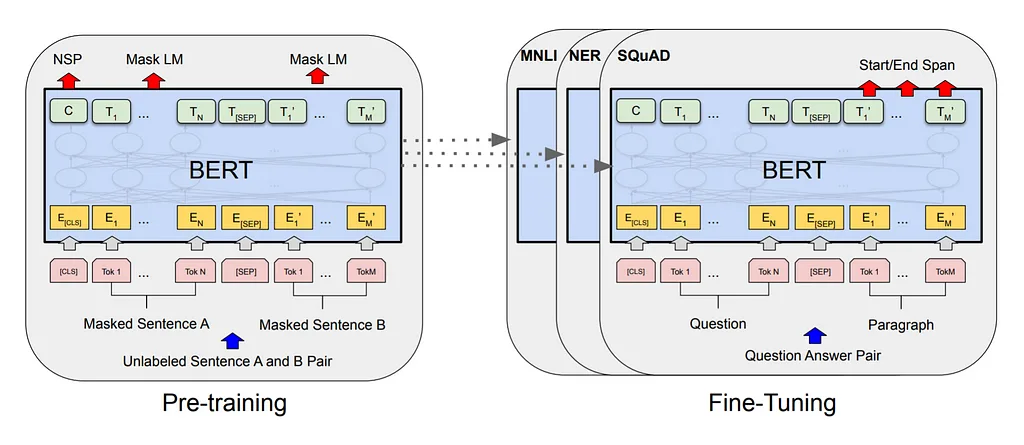

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Sentiment Classifications

In [27]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [28]:
tweet = pd.read_csv('/content/drive/MyDrive/Data/dropbox.csv')

In [29]:
tweet

,Sentiment,text,target
0,delighted,a lifesaver thanks,4
1,delighted,ash was great,4
2,delighted,awesome thanks dawn,4
3,delighted,celeste is the best and she deserves a raise,4
4,happy,didnt get what i was looking for but claudia h...,3
...,...,...,...
14151,irritated,tell me how to resolve the issue? i appreciate...,0
14152,irritated,the response i received seemed like boilerplat...,0
14153,delighted,dont charge renewal or end of trial when reque...,4
14154,irritated,not always recommend we try another browser or...,0


In [30]:
tweet.shape

(14156, 3)

In [31]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14156 entries, 0 to 14155
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  14156 non-null  object
 1   text       14156 non-null  object
 2   target     14156 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 331.9+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [32]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Emotions')

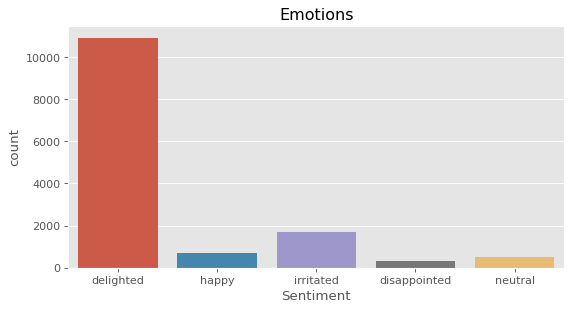

In [33]:
sns.countplot('Sentiment', data=tweet)
plt.title('Emotions')

In [34]:
tweet['Sentiment'].value_counts()

delighted       10920
irritated        1693
happy             716
neutral           519
disappointed      308
Name: Sentiment, dtype: int64

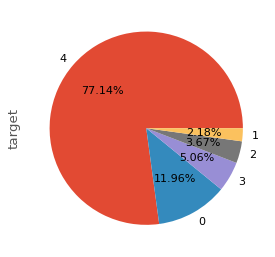

In [35]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [12]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-suld9ph8
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-suld9ph8
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp36-none-any.whl size=11742 sha256=7540c894883113d406054e5af918ebf606352bb50154702cdaf3c7ade8b24bed
  Stored in directory: /tmp/pip-ephem-wheel-cache-4f8al6n4/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [36]:
import preprocess_kgptalkie as kgp

In [37]:
tweet = kgp.get_basic_features(tweet)

In [38]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,delighted,a lifesaver thanks,4,16,3,5.333333,1,0,0,0,0
1,delighted,ash was great,4,11,3,3.666667,1,0,0,0,0
2,delighted,awesome thanks dawn,4,17,3,5.666667,0,0,0,0,0
3,delighted,celeste is the best and she deserves a raise,4,36,9,4.000000,5,0,0,0,0
4,happy,didnt get what i was looking for but claudia h...,3,51,12,4.250000,7,0,0,0,0


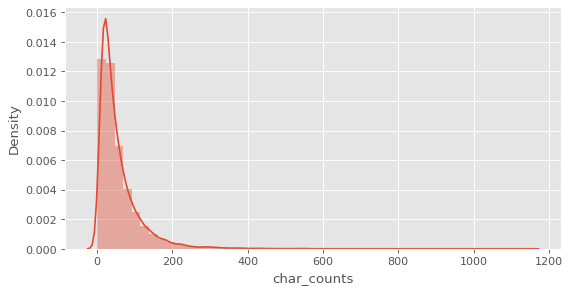

In [39]:
sns.distplot(tweet['char_counts'])

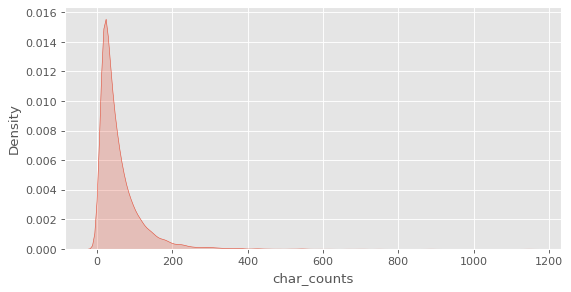

In [40]:
sns.kdeplot(tweet['char_counts'], shade=True)

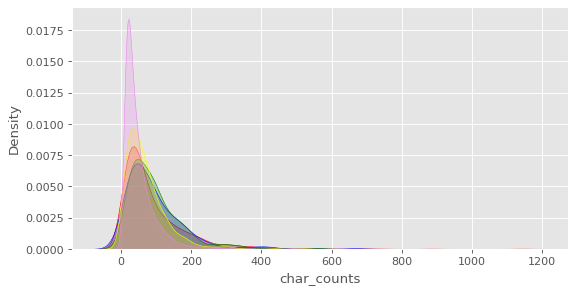

In [41]:
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['char_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['char_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['char_counts'], shade=True, color='violet')

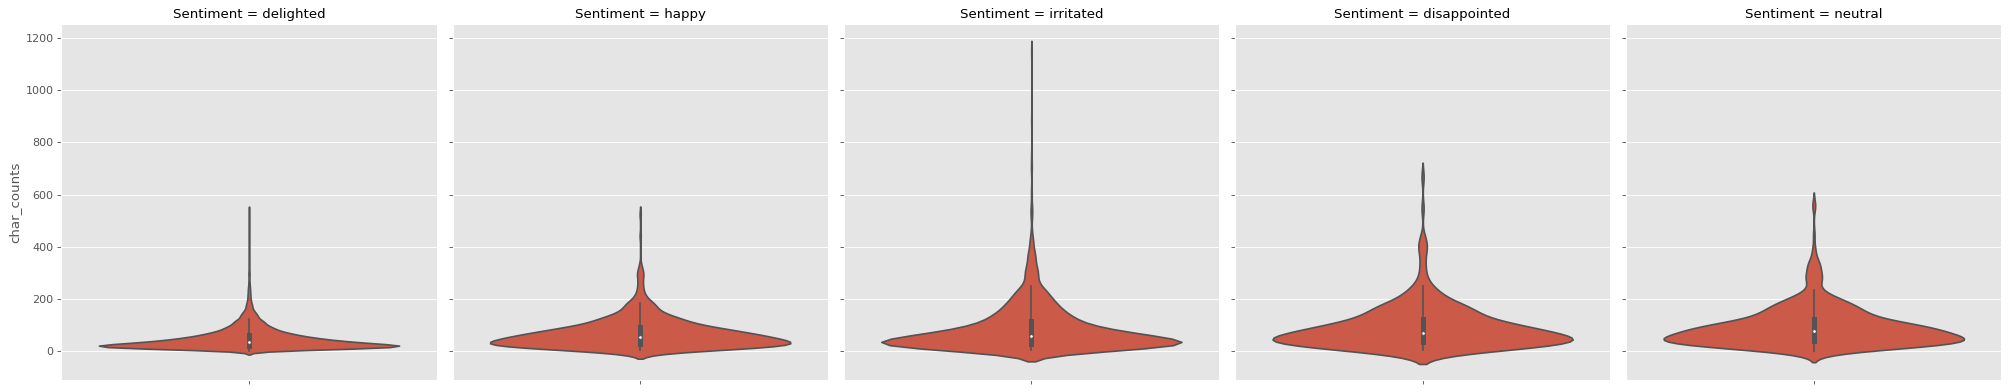

In [42]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='Sentiment')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

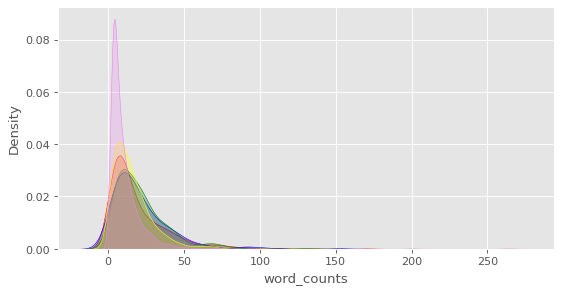

In [43]:
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['word_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['word_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['word_counts'], shade=True, color='violet')

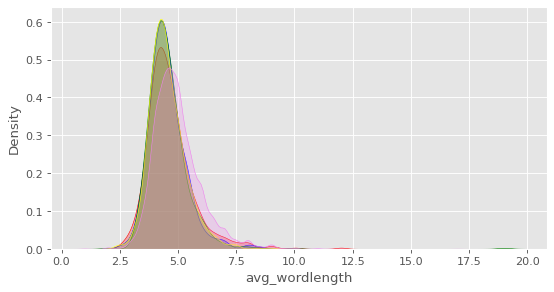

In [44]:
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['avg_wordlength'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['avg_wordlength'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['avg_wordlength'], shade=True, color='violet')


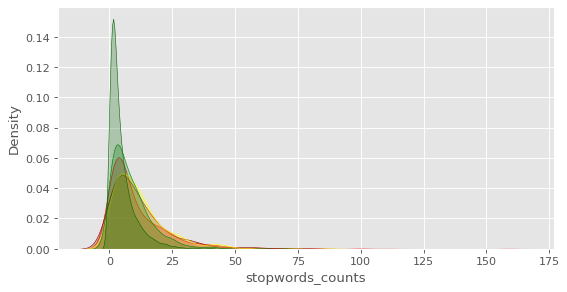

In [45]:
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='darkred')
sns.kdeplot(tweet[tweet['target']==2]['stopwords_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==3]['stopwords_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==4]['stopwords_counts'], shade=True, color='darkgreen')


In [46]:
tweet.columns

Index(['Sentiment', 'text', 'target', 'char_counts', 'word_counts',
       'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [47]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [48]:
top20 = freqs[100:120]

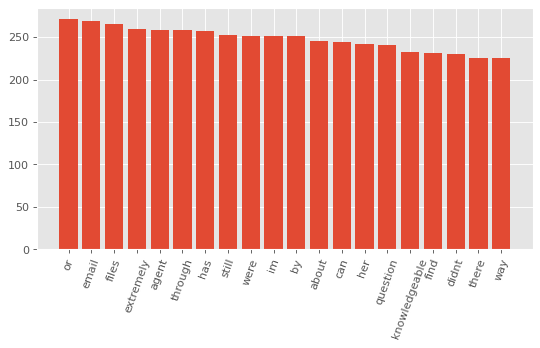

In [49]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [50]:
least20 = freqs[-20:]
least20

mb                 1
â€œrequest         1
accomodating       1
karen              1
accomplishing      1
elizabeth          1
beast              1
humpty             1
longterm           1
basis              1
demande            1
series             1
¸ë„¤ìš”            1
optimistic         1
dream              1
owens              1
professionality    1
adamant            1
treasured          1
bread              1
dtype: int64

In [51]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [53]:
bigram[-20:]

[('about accessing', 19),
 ('abort to', 18),
 ('abnormally great', 17),
 ('ablte to', 16),
 ('able unfortunately', 15),
 ('able to', 14),
 ('able respons', 13),
 ('able given', 12),
 ('able ask', 11),
 ('ability to', 10),
 ('ability that', 9),
 ('ability of', 8),
 ('ability in', 7),
 ('ability for', 6),
 ('abilitano dare', 5),
 ('abbiamo risolto', 4),
 ('abandoned or', 3),
 ('abandon it', 2),
 ('aaron who', 1),
 ('aaron my', 0)]

### One-Shot Data Cleaning

In [55]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [56]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [57]:
tweet.head()['text']

0                                   a lifesaver thanks
1                                        ash was great
2                                  awesome thanks dawn
3         celeste is the best and she deserves a raise
4    didnt get what i was looking for but claudia h...
Name: text, dtype: object

In [58]:
kgp.get_ngram(tweet, 'text', ngram_range=2)

[('zooming my', 53862),
 ('zoom miss', 53861),
 ('zoom conference', 53860),
 ('zoom assistants', 53859),
 ('zone am', 53858),
 ('zoes help', 53857),
 ('zoes fault', 53856),
 ('zoe was', 53855),
 ('zoe understood', 53854),
 ('zoe talked', 53853),
 ('zoe managed', 53852),
 ('zoe is', 53851),
 ('zoe for', 53850),
 ('zoe excellent', 53849),
 ('zoe did', 53848),
 ('zoe and', 53847),
 ('zn n1234', 53846),
 ('zipped file', 53845),
 ('zero wait', 53844),
 ('zero stars', 53843),
 ('zero resolution', 53842),
 ('zero help', 53841),
 ('zero dramas', 53840),
 ('zen desk', 53839),
 ('zealand have', 53838),
 ('zappos the', 53837),
 ('zachary was', 53836),
 ('zachary and', 53835),
 ('yrs and', 53834),
 ('yr old', 53833),
 ('yr db', 53832),
 ('ypu pierce', 53831),
 ('youy didnt', 53830),
 ('youve made', 53829),
 ('youve had', 53828),
 ('youve been', 53827),
 ('youve all', 53826),
 ('youve added', 53825),
 ('yourselves available', 53824),
 ('yourself thats', 53823),
 ('yourself in', 53822),
 ('yourself 

### Disaster Words Visualization with Word Cloud



In [59]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'to the i a and was not my it have but is of for that on me dropbox in support issue you chat with be this problem help get an very email no phone did so had could do as all still am time didnt would been find answer your account what from should helpful or more person way question at how we need he agent if provide are call resolved contact out up response solve files when work back being someone able by its service like they without tried information than easy make there over needed solution good great about took dont customer days end one use after know she were see understand where through just who folders can only got team questions resolve other link available speak please number first option long told try has actually before box card give im screen go why clear wasnt trying access instructions cant then which using want too much solved asked process rep sure fine people easier offer business done difficult website refund sync already web charged now will any something address re

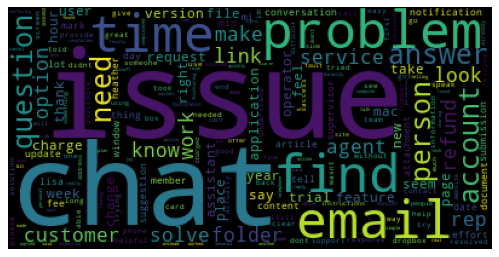

In [72]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

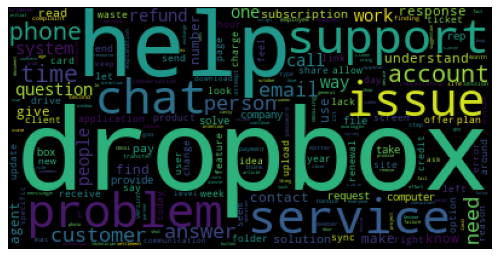

In [71]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

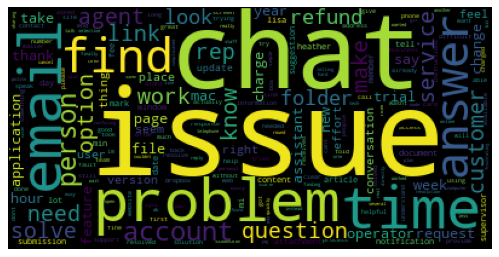

In [70]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

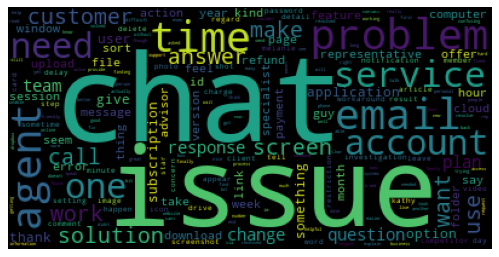

In [69]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==2], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

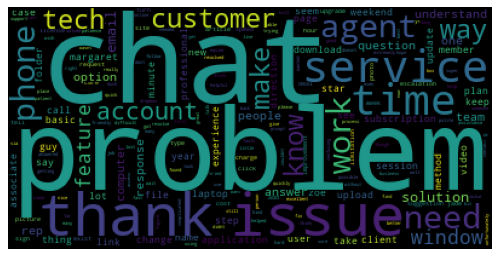

In [68]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==3], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

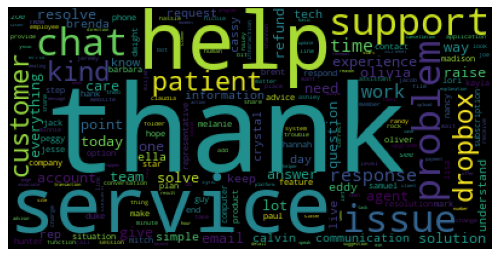

In [67]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==4], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [73]:
text = tweet['text']
y = tweet['target']

In [74]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [75]:
X.shape

(14156, 7006)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [77]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [78]:
from sklearn.svm import LinearSVC

In [79]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       339
           1       0.12      0.02      0.03        62
           2       0.26      0.09      0.13       104
           3       0.26      0.10      0.14       143
           4       0.90      0.96      0.93      2184

    accuracy                           0.84      2832
   macro avg       0.44      0.38      0.38      2832
weighted avg       0.80      0.84      0.81      2832



## Classification with `Word2Vec` and SVM


In [48]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180945 sha256=83a45fbba5d896b0f3919916a6a9b1f417ae1665a7d3e7d5dbf17fc01a465597
  Stored in directory: /tmp/pip-ephem-wheel-cache-80if_omz/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [80]:
import spacy
import en_core_web_lg

In [81]:
nlp = en_core_web_lg.load()

In [82]:
x = 'cat dog'
doc = nlp(x)

In [83]:
doc.vector.shape

(300,)

In [84]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [85]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [86]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,delighted,a lifesaver thanks,4,16,3,5.333333,1,0,0,0,0,"[-0.061137136, -0.023777002, -0.049896672, 0.3..."
1,delighted,ash was great,4,11,3,3.666667,1,0,0,0,0,"[-0.176338, 0.34346566, -0.009377002, -0.17373..."
2,delighted,awesome thanks dawn,4,17,3,5.666667,0,0,0,0,0,"[-0.13240667, 0.13631949, -0.14011632, -0.0886..."
3,delighted,celeste is the best and she deserves a raise,4,36,9,4.000000,5,0,0,0,0,"[-0.13739479, 0.22358131, -0.113740414, 0.0145..."
4,happy,didnt get what i was looking for but claudia h...,3,51,12,4.250000,7,0,0,0,0,"[-0.05408738, 0.22286803, -0.22507499, -0.1197..."


In [87]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [88]:
X.shape

(14156, 1)

In [89]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [90]:
X.shape

(14156, 300)

In [91]:
y = tweet['target']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [93]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       339
           1       0.50      0.02      0.03        62
           2       0.08      0.01      0.02       104
           3       0.25      0.02      0.04       143
           4       0.88      0.97      0.92      2184

    accuracy                           0.84      2832
   macro avg       0.47      0.35      0.34      2832
weighted avg       0.78      0.84      0.80      2832

CPU times: user 22.7 s, sys: 65.3 ms, total: 22.8 s
Wall time: 22.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Word Embeddings and Classification with Deep Learning


In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [95]:
text

0                                       a lifesaver thanks
1                                            ash was great
2                                      awesome thanks dawn
3             celeste is the best and she deserves a raise
4        didnt get what i was looking for but claudia h...
                               ...                        
14151    tell me how to resolve the issue i appreciate ...
14152    the response i received seemed like boilerplat...
14153    dont charge renewal or end of trial when reque...
14154    not always recommend we try another browser or...
14155                                   responding quicker
Name: text, Length: 14156, dtype: object

In [96]:
token = Tokenizer()
token.fit_on_texts(text)

In [97]:
vocab_size = len(token.word_index) + 1
vocab_size

7030

In [98]:
print(token.word_index)

{'and': 1, 'was': 2, 'to': 3, 'the': 4, 'i': 5, 'very': 6, 'a': 7, 'my': 8, 'helpful': 9, 'you': 10, 'great': 11, 'with': 12, 'for': 13, 'me': 14, 'is': 15, 'it': 16, 'help': 17, 'thank': 18, 'service': 19, 'not': 20, 'of': 21, 'support': 22, 'thanks': 23, 'that': 24, 'in': 25, 'dropbox': 26, 'have': 27, 'issue': 28, 'easy': 29, 'quick': 30, 'chat': 31, 'problem': 32, 'but': 33, 'so': 34, 'this': 35, 'on': 36, 'be': 37, 'customer': 38, 'fast': 39, 'all': 40, 'your': 41, 'patient': 42, 'good': 43, 'get': 44, 'excellent': 45, 'an': 46, 'what': 47, 'no': 48, 'as': 49, 'had': 50, 'he': 51, 'much': 52, 'super': 53, 'time': 54, 'from': 55, 'she': 56, 'did': 57, 'solved': 58, 'quickly': 59, 'am': 60, 'resolved': 61, 'really': 62, 'friendly': 63, 'person': 64, 'would': 65, 'at': 66, 'efficient': 67, 'helped': 68, 'awesome': 69, 'questions': 70, 'out': 71, 'response': 72, 'will': 73, 'nice': 74, 'needed': 75, 'account': 76, 'just': 77, 'work': 78, 'been': 79, 'do': 80, 'able': 81, 'professional

In [99]:
encoded_text = token.texts_to_sequences(text)

In [100]:
print(encoded_text)

[[7, 2210, 23], [3511, 2, 11], [69, 23, 297], [328, 15, 4, 92, 1, 56, 528, 7, 229], [118, 44, 47, 5, 2, 341, 13, 33, 688, 68, 14, 59], [1430, 2, 6, 9], [45, 22, 23], [1702, 2667], [104, 9, 18, 10], [11, 17], [11, 19, 18, 10], [5, 50, 3, 424, 91, 3, 117, 17, 179, 24, 16, 2, 29], [5, 256, 3, 3512, 12, 35, 31], [703, 2, 6, 9, 3, 502, 14, 23], [204, 2, 6, 9, 1, 201, 5, 50, 8, 70, 593, 1, 61, 59], [332, 2, 6, 9], [8, 1254, 2, 6, 235, 1, 953, 2, 34, 42, 18, 10], [453, 61, 240, 32, 6, 59, 18, 10], [34, 11], [22, 2, 53, 39, 1, 53, 67], [18, 10], [23], [23, 13, 954, 8, 32], [23, 323, 10, 27, 79, 6, 9, 127, 16, 53, 29, 1, 90, 36, 88, 3, 529, 71, 4, 28, 5, 50], [23, 369], [23], [4, 544, 138, 2, 266, 33, 4, 480, 342, 468, 2, 490, 20, 3513, 385], [4, 22, 15, 279, 11], [35, 15, 4, 634, 54, 24, 5, 27, 226, 4, 348, 70, 33, 20, 284, 79, 435, 46, 96, 1332, 3, 152, 721, 530, 54, 1255, 635, 14], [6, 842, 1, 42, 11, 19], [6, 29, 3, 31, 671, 58, 8, 32], [6, 9], [6, 30, 333, 1, 374, 158, 55, 370, 18, 10], [6

In [101]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [102]:
print(X)

[[   7 2210   23 ...    0    0    0]
 [3511    2   11 ...    0    0    0]
 [  69   23  297 ...    0    0    0]
 ...
 [ 161  559  731 ...    0    0    0]
 [  20  289  438 ...    0    0    0]
 [ 825  887    0 ...    0    0    0]]


In [103]:
X.shape

(14156, 40)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [105]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.4 µs


In [106]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           703000    
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [108]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
354/354 [==============================] - 6s 10ms/step - loss: -25585.0566 - accuracy: 0.0294 - val_loss: -915512.6875 - val_accuracy: 0.0219
Epoch 2/5
354/354 [==============================] - 3s 9ms/step - loss: -8543426.4729 - accuracy: 0.0217 - val_loss: -52406248.0000 - val_accuracy: 0.0219
Epoch 3/5
354/354 [==============================] - 3s 9ms/step - loss: -163895133.1380 - accuracy: 0.0211 - val_loss: -438621536.0000 - val_accuracy: 0.0219
Epoch 4/5
354/354 [==============================] - 3s 10ms/step - loss: -1020285134.0620 - accuracy: 0.0220 - val_loss: -1808976896.0000 - val_accuracy: 0.0219
Epoch 5/5
354/354 [==============================] - 4s 10ms/step - loss: -3631195609.0592 - accuracy: 0.0222 - val_loss: -5136695296.0000 - val_accuracy: 0.0219
CPU times: user 34.4 s, sys: 4.49 s, total: 38.9 s
Wall time: 20 s


In [109]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [110]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [111]:
vec

array([[   5,   60, 5845,    3,  244,   35,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [112]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [84]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 1.3MB/s 
     |████████████████████████████████| 6.8MB 48.7MB/s 
     |████████████████████████████████| 983kB 51.2MB/s 
     |████████████████████████████████| 266kB 61.7MB/s 
     |████████████████████████████████| 1.3MB 49.5MB/s 
     |████████████████████████████████| 1.2MB 52.7MB/s 
     |████████████████████████████████| 471kB 52.7MB/s 
     |████████████████████████████████| 2.9MB 52.8MB/s 
     |████████████████████████████████| 890kB 63.5MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.4-cp36-none-any.whl size=25276443 sha256=cf4fa0164606d17b87af074341d2180639ee17c9d9ef85fb0d46b7b63e4a7dc5
  Stored in directory: /root/.cache/pip/wheels/1b/77/8a/bdceaabc308e7178d575278bf6143b7d1a9b939a1e40c56b88
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=0d8d6008ccd709f217b4d12d412021d7b7139fe1dcb801d10a8e7f8f7fca0eb7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [113]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,delighted,a lifesaver thanks,4,16,3,5.333333,1,0,0,0,0,"[-0.061137136, -0.023777002, -0.049896672, 0.3..."
1,delighted,ash was great,4,11,3,3.666667,1,0,0,0,0,"[-0.176338, 0.34346566, -0.009377002, -0.17373..."
2,delighted,awesome thanks dawn,4,17,3,5.666667,0,0,0,0,0,"[-0.13240667, 0.13631949, -0.14011632, -0.0886..."
3,delighted,celeste is the best and she deserves a raise,4,36,9,4.000000,5,0,0,0,0,"[-0.13739479, 0.22358131, -0.113740414, 0.0145..."
4,happy,didnt get what i was looking for but claudia h...,3,51,12,4.250000,7,0,0,0,0,"[-0.05408738, 0.22286803, -0.22507499, -0.1197..."


In [114]:
from ktrain import text
import ktrain

In [115]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [116]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [142]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [159]:
#learner.fit_onecycle(lr = 2e-5, epochs=1)
learner.fit_onecycle(lr = 1.5e-7, epochs=1)



begin training using onecycle policy with max lr of 1.5e-07...
200/200 [==============================] - 73s 308ms/step - loss: 0.8111 - accuracy: 0.7723 - val_loss: 0.8123 - val_accuracy: 0.7634


In [121]:
#learner.fit_onecycle(lr = 2e-5, epochs=3)
learner.fit_onecycle(lr = 1.5e-2, epochs=10)



begin training using onecycle policy with max lr of 0.015...
Epoch 1/10
200/200 [==============================] - 58s 292ms/step - loss: 0.8614 - accuracy: 0.7723 - val_loss: 0.9509 - val_accuracy: 0.7634
Epoch 2/10
 37/200 [====>.........................] - ETA: 46s - loss: 0.8982 - accuracy: 0.7817

KeyboardInterrupt: ignored

In [ ]:
#learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 1e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
219/219 [==============================] - 90s 413ms/step - loss: 1.2865 - accuracy: 0.4021 - val_loss: 1.3052 - val_accuracy: 0.3774
Epoch 2/3
219/219 [==============================] - 91s 414ms/step - loss: 1.2883 - accuracy: 0.4031 - val_loss: 1.3033 - val_accuracy: 0.3774
Epoch 3/3
 14/219 [>.............................] - ETA: 1:23 - loss: 1.2525 - accuracy: 0.3917

KeyboardInterrupt: ignored

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
200/200 [==============================] - 57s 283ms/step - loss: 0.8111 - accuracy: 0.7723
Epoch 2/1024
200/200 [==============================] - 57s 284ms/step - loss: 0.8107 - accuracy: 0.7723
Epoch 3/1024
200/200 [==============================] - 57s 284ms/step - loss: 0.8104 - accuracy: 0.7723
Epoch 4/1024
200/200 [==============================] - 57s 283ms/step - loss: 0.8121 - accuracy: 0.7723
Epoch 5/1024
200/200 [==============================] - 57s 284ms/step - loss: 0.8251 - accuracy: 0.7723
Epoch 6/1024
200/200 [==============================] - 57s 284ms/step - loss: 1.1597 - accuracy: 0.7283
Epoch 7/1024
200/200 [==============================] - 17s 82ms/step - loss: 4.6300 - accuracy: 0.6307


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


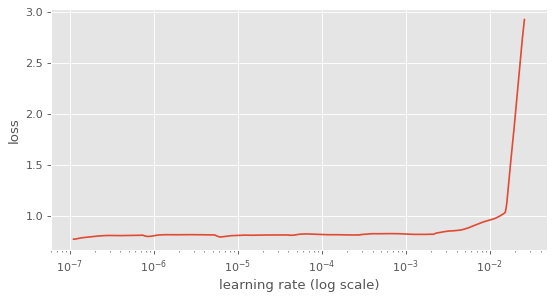

In [158]:
# find out best learning rate?
learner.lr_find()
learner.lr_plot()
#learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.autofit(1e-6)
# it may take days or many days to find out.

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-06...
Epoch 1/1024
219/219 [==============================] - 104s 429ms/step - loss: 1.2849 - accuracy: 0.4055 - val_loss: 1.3033 - val_accuracy: 0.3774
Epoch 2/1024
219/219 [==============================] - 92s 419ms/step - loss: 1.2848 - accuracy: 0.4055 - val_loss: 1.3035 - val_accuracy: 0.3774
Epoch 3/1024
219/219 [==============================] - 92s 419ms/step - loss: 1.2847 - accuracy: 0.4055 - val_loss: 1.3036 - val_accuracy: 0.3774

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-07 (if not early_stopping).
Epoch 4/1024
219/219 [==============================] - 92s 419ms/step - loss: 1.2847 - accuracy: 0.4055 - val_loss: 1.3037 - val_accuracy: 0.3774
Epoch 5/1024
219/219 [==============================] - 92s 419ms/step - loss: 1.2847 - accuracy: 0.4055 - val_loss: 1.3038 - val_accur

In [160]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [144]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [145]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[0.11120994, 0.02292128, 0.04106585, 0.06102376, 0.76377916],
       [0.11120996, 0.02292128, 0.04106585, 0.06102377, 0.76377916]],
      dtype=float32)

In [146]:
predictor.predict(data[1])

'target_4'

In [147]:
classes = predictor.get_classes()

In [148]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [149]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

4

In [150]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [131]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [132]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [133]:
predictor.predict(data)

['target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4']

In [134]:
predictor.predict(data, return_proba=True)

array([[0.11120998, 0.02292129, 0.04106585, 0.06102377, 0.76377916],
       [0.11120998, 0.02292128, 0.04106585, 0.06102376, 0.76377916],
       [0.11120996, 0.02292129, 0.04106586, 0.06102377, 0.76377916],
       [0.11120998, 0.02292128, 0.04106585, 0.06102377, 0.76377916],
       [0.11120993, 0.02292128, 0.04106583, 0.06102376, 0.76377916],
       [0.11120997, 0.02292128, 0.04106585, 0.06102377, 0.7637791 ],
       [0.11121   , 0.02292128, 0.04106585, 0.06102378, 0.76377904]],
      dtype=float32)

In [ ]:
predictor.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [161]:
predictor.save('/content/drive/MyDrive/Data/bertTP')

In [162]:
!zip -r /content/drive/MyDrive/Data/bertTP/bert.zip /content/drive/MyDrive/Data/bertTP

updating: content/drive/MyDrive/Data/bertTP/ (stored 0%)
updating: content/drive/MyDrive/Data/bertTP/tf_model.h5 (deflated 18%)
updating: content/drive/MyDrive/Data/bertTP/tf_model.preproc (deflated 52%)
updating: content/drive/MyDrive/Data/bertTP/.ipynb_checkpoints/ (stored 0%)


In [163]:
predictor_load = ktrain.load_predictor('/content/drive/MyDrive/Data/bertTP')

In [164]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [165]:
predictor_load.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [166]:
predictor_load.predict(data)

['target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4',
 'target_4']

In [157]:
predictor_load.predict(data, return_proba=True)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[0.11120994, 0.02292128, 0.04106585, 0.06102376, 0.76377916],
       [0.11120996, 0.02292128, 0.04106585, 0.06102377, 0.76377916]],
      dtype=float32)